In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import random
import cv2
from tqdm import tqdm
import dgl
import networkx as nx
from torchvision.datasets import VOCSegmentation
from torchvision import transforms
import torchvision.transforms.functional as F

from torchvision.io.image import read_image
from torchvision.models.segmentation import deeplabv3_resnet101,DeepLabV3_ResNet101_Weights
from torchvision.transforms.functional import to_pil_image

import modules

<class 'torch.Tensor'>


c:\Users\kisim\anaconda3\envs\GNN_DGL\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


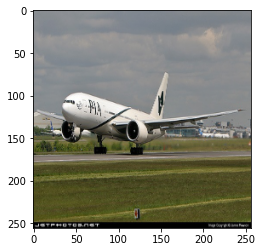

In [2]:
image=read_image('./VOC/VOCdevkit/VOC2012/JPEGImages/2007_000256.jpg')
print(type(image))
image=F.resize(image,size=(256,256))
image=np.array(image).transpose(1,2,0)
plt.imshow(image)
plt.show()

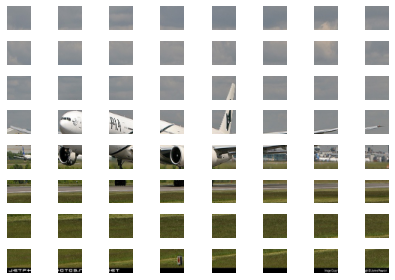

[array([[[136, 141, 145],
         [136, 141, 145],
         [134, 139, 143],
         ...,
         [140, 143, 148],
         [141, 144, 149],
         [138, 141, 146]],
 
        [[139, 144, 148],
         [138, 143, 147],
         [137, 142, 146],
         ...,
         [140, 143, 148],
         [140, 143, 148],
         [139, 142, 147]],
 
        [[138, 143, 147],
         [138, 143, 147],
         [138, 143, 147],
         ...,
         [140, 143, 148],
         [140, 143, 148],
         [140, 143, 148]],
 
        ...,
 
        [[146, 146, 150],
         [146, 146, 148],
         [146, 146, 148],
         ...,
         [134, 139, 145],
         [133, 138, 144],
         [132, 137, 143]],
 
        [[146, 146, 151],
         [146, 146, 148],
         [147, 147, 149],
         ...,
         [139, 142, 146],
         [140, 143, 147],
         [138, 140, 145]],
 
        [[146, 147, 151],
         [146, 146, 149],
         [147, 147, 149],
         ...,
         [147, 147, 149],
  

In [3]:
modules.img2patch(image,8,views=True)

c:\Users\kisim\anaconda3\envs\GNN_DGL\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


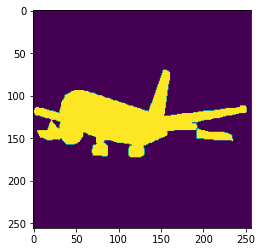

In [8]:
mask=read_image('./VOC/VOCdevkit/VOC2012/SegmentationClass/2007_000256.png')
mask=F.resize(mask,size=(256,256))
mask=np.array(mask).transpose(1,2,0)
mask=np.where(mask!=0,255,mask)
plt.imshow(mask,vmin=0,vmax=255)
plt.show()

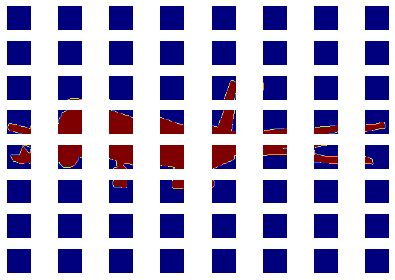

[array([[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        ...,
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]], dtype=uint8),
 array([[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        ...,
 
        [[0],
         [0],
         [0],
      

In [9]:
modules.img2patch(mask,8,cmap='jet',views=True)

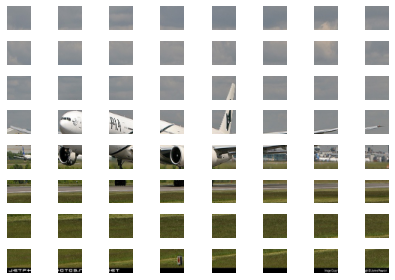

In [11]:
data=modules.img2patch(image,8,cmap='jet',views=True)

In [13]:
class_name_path='./VOC make graph info/info/class info.txt'
cls_name_index={}
with open(class_name_path,'r') as file:
    image_names=[line.strip() for line in file]
print(image_names)
for num,img_name in enumerate(image_names):
    cls_name_index[img_name]=num
print(cls_name_index)

['chair', 'boat', 'train', 'cow', 'sofa', 'motorbike', 'diningtable', 'bus', 'horse', 'cat', 'bicycle', 'bottle', 'tvmonitor', 'aeroplane', 'person', 'dog', 'pottedplant', 'car', 'bird', 'sheep']
{'chair': 0, 'boat': 1, 'train': 2, 'cow': 3, 'sofa': 4, 'motorbike': 5, 'diningtable': 6, 'bus': 7, 'horse': 8, 'cat': 9, 'bicycle': 10, 'bottle': 11, 'tvmonitor': 12, 'aeroplane': 13, 'person': 14, 'dog': 15, 'pottedplant': 16, 'car': 17, 'bird': 18, 'sheep': 19}


In [12]:
for cls in image_names:
    with open(f'./VOC make graph info/{cls}_image.txt','r') as f:
        image_path=[line.strip() for line in f]
    print(len(image_path),int(len(image_path)*0.8),len(image_path) - int(len(image_path)*0.8))

33 26 7
103 82 21
134 107 27
101 80 21
39 31 8
58 46 12
9 7 2
72 57 15
80 64 16
186 148 38
44 35 9
61 48 13
57 45 12
153 122 31
136 108 28
156 124 32
54 43 11
94 75 19
187 149 38
103 82 21


In [15]:
#トレーニング用グラフデータ保存リスト
#テスト用グラフデータ保存リスト
#完全グラフ作成用隣接行列
#1．上記の変数を初期化
#2．クラス名テキストファイルから画像ファイルパスを読み取り
#3．先頭から8割をトレーニング用2割をテスト用としてグラフ作成
#4．ファイルパスから元画像とマスク画像を読み込むー256x256にリサイズしマスク画像に関して背景以外を255にそろえておく
#5．マスク画像についてパッチ内の255の数の割合が10％以上であれば1を出力する処理を全パッチで行い1，0からなる2次元リストを取得
#6．完全グラフを作成しノードに'f'として元画像のパッチ画像を代入、'o'として物体があるかないかを示すリストを代入
#7．すべてのクラス画像が完了したらグラフをそれぞれ保存

In [18]:
#パッチ数
num_patch=8

#隣接行列
adjacency_matrix=np.ones((num_patch,num_patch),dtype=np.uint8)

#データ保存用リスト
train_graphs=[]
test_graphs=[]
train_labels=[]
test_labels=[]

class_name_path='./VOC make graph info/info/class info.txt'
#クラス名とインデックスの辞書：{'chair':0, ...}
cls_name_index={}

with open(class_name_path,'r') as file:
    image_names=[line.strip() for line in file]
for num,img_name in enumerate(image_names):
    cls_name_index[img_name]=num
print(cls_name_index)

#ループ開始
for cls in tqdm(image_names):
    with open(f'./VOC make graph info/{cls}_image.txt','r') as f:
        image_path=[line.strip() for line in f]
    train_num=int(len(image_path)*0.8) #トレーニングデータ数
    test_num=len(image_path) - int(len(image_path)*0.8) #テストデータ数
    cls_index=cls_name_index[cls]
    #トレーニングデータ用グラフ作成
    for img_path in image_path[:train_num]:
        #元画像読み込み
        image=read_image(f'./VOC/VOCdevkit/VOC2012/JPEGImages/{img_path}.jpg')
        #256にリサイズ
        image=F.resize(image,size=(256,256))
        #パッチに分割しそのままノード特徴として保存
        node_feat=modules.img2patch(image,num_patch)

        #マスク画像読み込み
        mask=read_image(f'./VOC/VOCdevkit/VOC2012/SegmentationClass/{img_path}.png')
        #256にリサイズ
        mask=F.resize(mask,size=(256,256))
        #背景(0)以外を255に置換
        mask=np.where(mask!=0,255,mask)
        #パッチに分割し変数に保存
        mask_patch=modules.img2patch(torch.from_numpy(mask),num_patch)
        #各ノードが物体を示すのかどうかを示すリスト
        object_matrix=torch.tensor([[1 if torch.sum(patch==255).item() / num_patch**2 >=0.1 else 0] for patch in mask_patch])

        #グラフ作成
        g=nx.complete_graph(num_patch**2)
        G=dgl.from_networkx(g)
        G.ndata['f']=node_feat
        G.ndata['o']=object_matrix

        #完成グラフとラベルを保存用リストにアペンド
        train_graphs.append(G)
        train_labels.append([cls_name_index[cls]])
    
    #テストデータ用グラフ作成
    for img_path in image_path[-test_num:]:
        #元画像読み込み
        image=read_image(f'./VOC/VOCdevkit/VOC2012/JPEGImages/{img_path}.jpg')
        #256にリサイズ
        image=F.resize(image,size=(256,256))
        #パッチに分割しそのままノード特徴として保存
        node_feat=modules.img2patch(image,num_patch)

        #マスク画像読み込み
        mask=read_image(f'./VOC/VOCdevkit/VOC2012/SegmentationClass/{img_path}.png')
        #256にリサイズ
        mask=F.resize(mask,size=(256,256))
        #背景(0)以外を255に置換
        mask=np.where(mask!=0,255,mask)
        #パッチに分割し変数に保存
        mask_patch=modules.img2patch(torch.from_numpy(mask),num_patch)
        #各ノードが物体を示すのかどうかを示すリスト
        object_matrix=torch.tensor([[1 if torch.sum(patch==255).item() / num_patch**2 >=0.1 else 0] for patch in mask_patch])

        #グラフ作成
        g=nx.complete_graph(num_patch**2)
        G=dgl.from_networkx(g)
        G.ndata['f']=node_feat
        G.ndata['o']=object_matrix

        #完成グラフとラベルを保存用リストにアペンド
        test_graphs.append(G)
        test_labels.append([cls_name_index[cls]])

#グラフの保存
train_output_labels={'label':torch.tensor(train_labels)}
path=f'../data/VOC/train/8patch_rgb.dgl'
dgl.save_graphs(path,g_list=train_graphs,labels=train_output_labels)

test_output_labels={'label':torch.tensor(test_labels)}
path=f'../data/VOC/test/8patch_rgb.dgl'
dgl.save_graphs(path,g_list=test_graphs,labels=test_output_labels)

{'chair': 0, 'boat': 1, 'train': 2, 'cow': 3, 'sofa': 4, 'motorbike': 5, 'diningtable': 6, 'bus': 7, 'horse': 8, 'cat': 9, 'bicycle': 10, 'bottle': 11, 'tvmonitor': 12, 'aeroplane': 13, 'person': 14, 'dog': 15, 'pottedplant': 16, 'car': 17, 'bird': 18, 'sheep': 19}


  0%|          | 0/20 [00:00<?, ?it/s]c:\Users\kisim\anaconda3\envs\GNN_DGL\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 20/20 [00:42<00:00,  2.11s/it]


In [19]:
print(len(train_graphs))

1479


In [20]:
print(len(test_graphs))

381


In [2]:
mat=np.random.choice([0,255],size=(8,8))
print(mat)

[[  0   0 255 255   0 255   0 255]
 [  0   0   0 255 255   0   0 255]
 [  0 255 255   0 255   0 255   0]
 [  0 255   0   0 255   0   0   0]
 [255 255   0   0 255 255   0 255]
 [  0 255   0   0   0 255 255   0]
 [  0   0 255   0   0   0 255   0]
 [255 255   0 255 255 255 255 255]]


In [9]:
print(np.sum(mat==255))
print(mat.size)

30
64


In [4]:
torch_mat=torch.tensor(mat)
print(torch_mat)

tensor([[  0,   0, 255, 255,   0, 255,   0, 255],
        [  0,   0,   0, 255, 255,   0,   0, 255],
        [  0, 255, 255,   0, 255,   0, 255,   0],
        [  0, 255,   0,   0, 255,   0,   0,   0],
        [255, 255,   0,   0, 255, 255,   0, 255],
        [  0, 255,   0,   0,   0, 255, 255,   0],
        [  0,   0, 255,   0,   0,   0, 255,   0],
        [255, 255,   0, 255, 255, 255, 255, 255]], dtype=torch.int32)


In [8]:
print(torch.sum(torch_mat==255).item())
print(torch_mat.size())

30
torch.Size([8, 8])


In [6]:
a=[torch.tensor([1,2,3]),torch.tensor([4,5,6])]

b=torch.stack(a)

print(a)
print(b)


[tensor([1, 2, 3]), tensor([4, 5, 6])]
tensor([[1, 2, 3],
        [4, 5, 6]])
